# [OCR(Optical Character Recognition)](https://m.blog.naver.com/rdproject/222113275331)
- OCR이란, Optical Character Recognition의 줄임말로, 이미지 내의 글자를 자동으로 인식하는 인공지능 기술을 의미합니다.
  - 예를 들어, 카메라를 통해 자동차 번호를 인식한다거나, 신분증에서 개인 정보 텍스트를 인식하는 등의 기술입니다.
  - 최근 OCR은 딥러닝으로 인해 큰 발전을 이루고 있습니다.

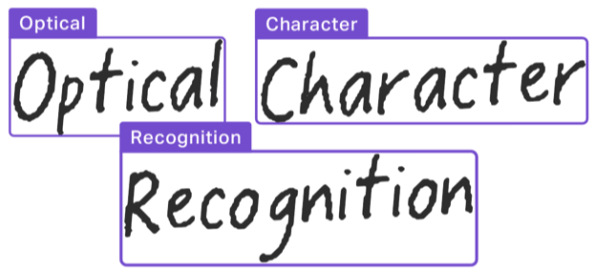

## 딥러닝과 OCR
딥러닝의 발전은 OCR에 큰 영향을 끼쳤습니다. 딥러닝의 핵심이라고 할 수 있는  CNN(Convolutional neural networks)에서 그 이유를 찾을 수 있습니다.
- CNN에서는 이미지의 특징을 추출하여 분류하는데, 이를 통해 기존의 전통적인 OCR 구조에서 개발자가 직접 설정해 주어야 했던 feature 인식 모듈은 더 이상 필요하지 않게 된 것입니다.
- 그 결과, 현재의 OCR은 딥러닝을 적용한 OCR은 글자의 영역을 탐지하는 모델(Text Detection Model)과 해당 영역에서 글자를 인식하는 모델(Text Recognition Model) 두 가지 단계로 구성되어 있습니다.
- 이처럼 OCR의 과정을 두 단계로 나누는 이유는 데이터를 다양하게 활용하여 원활한 학습이 가능하고, 자원의 효율성과 언어별 정확도 등을 향상시킬 수 있기 때문입니다.

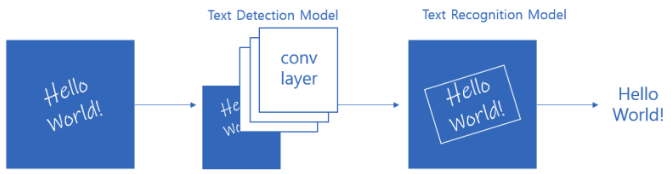

# [CRNN](https://blog.mathpresso.com/crnn-%EB%85%BC%EB%AC%B8-%EC%86%8C%EA%B0%9C-%EB%B0%8F-%EA%B5%AC%ED%98%84-60a8cbf9bbe5)
> [논문](https://arxiv.org/abs/1507.05717?source=post_page-----60a8cbf9bbe5--------------------------------)

- 본 논문을 한줄로 요약하면, `CNN과 RNN, CTC loss를 사용하여 input으로 부터 시퀀스를 인식하는 것`입니다.
- 시퀀스를 인식하는 다양한 부분에 적용할 수 있으나 본 논문에서는 이미지(input)로부터 텍스트(output) 시퀀스를 추출하는 것에 대해서 설명하고 있습니다.

## 네트워크 구조
- `Convolutional Layer`
  - 입력 이미지로부터 특징 시퀀스를 추출.
  - CNN을 통해서 input 이미지로 부터 feature sequence를 추출한다.
- `Recurrent Layers`
  - 각 프레임마다 라벨을 예측.
  - 추출한 feature sequence들을 RNN의 input으로 하여 이미지의 택스트 시퀀스를 예측한다.
- `Transcription Layers`
  - 프레임마다의 예측을 최종 라벨 시퀀스로 변경.
  - 예측된 텍스트 시퀀스를 텍스트로 변환한다.

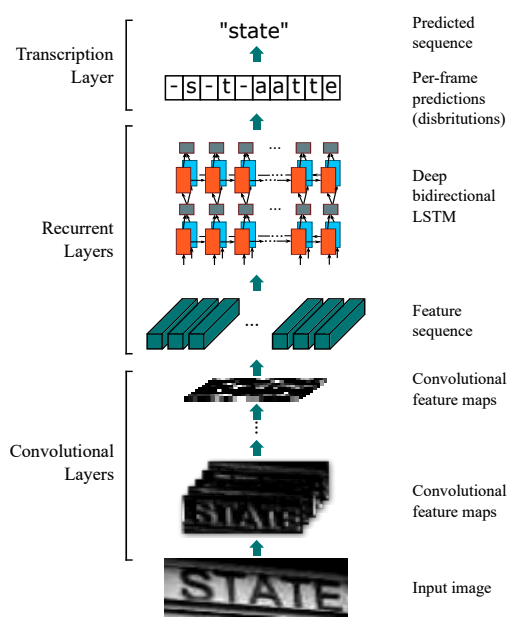

# [CRNN - 코드](https://github.com/carnotaur/crnn-tutorial/blob/master/CRNN%20Training.ipynb)

## import modules

In [1]:
import glob
import os
import string
from pathlib import Path
from tqdm.notebook import tqdm

from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet18
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.style.use('seaborn')

<ipython-input-2-447fa776aed2>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
import collections.abc as collections
from numpy import mean

class strLabelConverter(object):
    """Convert between str and label.
        Insert `blank` to the alphabet for CTC.
    Args:
        alphabet (str): set of the possible characters.
        ignore_case (bool, default=True): whether or not to ignore all of the case.
    """

    def __init__(self, alphabet: str, ignore_case: bool = True):
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()
        self.alphabet = alphabet + '-'  # for `-1` index

        self.char2idx = {}
        for i, char in enumerate(alphabet):
            # NOTE: 0 is reserved for 'blank' required by wrap_ctc
            self.char2idx[char] = i + 1
        self.idx2char = {idx: char for char, idx in self.char2idx.items()}

    def encode(self, text):
        """Support batch or single str.
        Args:
            text (str or list of str): texts to convert.
        Returns:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        """
        if isinstance(text, str):
            text = [
                self.char2idx[char.lower() if self._ignore_case else char]
                for char in text
            ]
            length = [len(text)]
        elif isinstance(text, collections.Iterable):
            length = [len(s) for s in text]
            text = ''.join(text)
            text, _ = self.encode(text)
        return (torch.IntTensor(text), torch.IntTensor(length))

    def decode(self, t, length, raw=False):
        """Decode encoded texts back into strs.
        Args:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        Raises:
            AssertionError: when the texts and its length does not match.
        Returns:
            text (str or list of str): texts to convert.
        """
        if length.numel() == 1:
            length = length[0]
            assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(), length)
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t])
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                return ''.join(char_list)
        else:
            # batch mode
            assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(t.numel(), length.sum())
            texts = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                texts.append(
                    self.decode(
                        t[index:index + l], torch.IntTensor([l]), raw=raw))
                index += l
        return texts


In [5]:
def decode_prediction(logits: torch.Tensor,
                      label_converter: strLabelConverter) -> str:
    tokens = logits.softmax(2).argmax(2)
    tokens = tokens.squeeze(1).numpy()

    # convert tor stings tokens
    tokens = ''.join([label_converter.idx2char[token]
                      if token != 0  else '-'
                      for token in tokens])
    tokens = tokens.split('-')

    # remove duplicates
    text = [char
            for batch_token in tokens
            for idx, char in enumerate(batch_token)
            if char != batch_token[idx-1] or len(batch_token) == 1]
    text = ''.join(text)
    return text


In [6]:
from IPython.display import clear_output

def plot_loss(epoch: int,
              train_losses: list,
              val_losses: list,
              n_steps: int = 100):
    """
    Plots train and validation losses
    """
    # clear previous graph
    clear_output(True)
    # making titles
    train_title = f'Epoch:{epoch} | Train Loss:{np.mean(train_losses[-n_steps:]):.6f}'
    val_title = f'Epoch:{epoch} | Val Loss:{np.mean(val_losses[-n_steps:]):.6f}'

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(train_losses)
    ax[1].plot(val_losses)

    ax[0].set_title(train_title)
    ax[1].set_title(val_title)

    plt.show()


In [7]:
def print_prediction(model, dataset, device, label_converter):
    idx = np.random.randint(len(dataset))
    path = dataset.pathes[idx]

    model.eval()
    with torch.no_grad():
        img, target_text = dataset[idx]
        img = img.unsqueeze(0)
        logits = model(img.to(device))

    pred_text = decode_prediction(logits.cpu(), label_converter)

    img = np.asarray(Image.open(path).convert('L'))
    title = f'Truth: {target_text} | Pred: {pred_text}'

    plt.imshow(img)
    plt.title(title)
    plt.axis('off');


## [Load Data](https://github.com/carnotaur/crnn-tutorial/tree/master/data)

In [11]:
# 구글 드라이브 연결(데이터 로드를 위해서)
try:
    from google.colab import drive

    drive.mount('/content/data')
    DATA_PATH = "/content/data/MyDrive/google_lecture/06. deep learning/3. NLP Pytorch/data/"
except:
    DATA_PATH = "./data/"

Mounted at /content/data


In [12]:
TRAIN_DIR = DATA_PATH+'crnn/train'
VAL_DIR = DATA_PATH+'crnn/val'

### EDA

In [13]:
images = os.listdir(TRAIN_DIR)
len(images)

856

In [14]:
images[0]

'nfcwy.png'

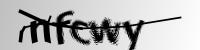

In [15]:
image = Image.open(TRAIN_DIR+"/"+images[0])
image

In [16]:
np.array(image).shape

(50, 200, 4)

### Vocabulary

In [17]:
alphabet = string.ascii_lowercase + string.digits
label_converter = strLabelConverter(alphabet)
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789'

## Dataset

In [18]:
class CRNNDataset(Dataset):
  def __init__(self, data_dir, transform=None):
    self.data_dir = data_dir
    self.data_paths = os.listdir(data_dir)
    self.pathes = [data_dir+"/"+_file_name for _file_name in self.data_paths]

    if transform:
      self.transform = transform
    else:
      self.transform = transforms.Compose([
          transforms.ToTensor()
      ])

  def __len__(self):
    return len(self.data_paths)

  def __getitem__(self, index):
    _file_name = self.data_paths[index]
    target = _file_name.split(".")[0].lower().strip()
    feature = Image.open(self.data_dir+"/"+_file_name).convert('RGB')
    feature = self.transform(feature)

    return feature, target


In [19]:
train_dt = CRNNDataset(TRAIN_DIR)
test_dt = CRNNDataset(VAL_DIR)

len(train_dt), len(test_dt)

(856, 214)

In [20]:
feature, target = train_dt[0]

# (color, height, width)
feature.shape, target

(torch.Size([3, 50, 200]), 'nfcwy')

## DataLoader

In [21]:
BATCH_SIZE = 8

train_loader = DataLoader(train_dt, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(test_dt, batch_size=BATCH_SIZE, shuffle=False)

len(train_loader), len(val_dataloader)

(107, 27)

In [22]:
imgs, texts = next(iter(val_dataloader))

# (batch, color, height, width)
imgs.shape, len(texts)

(torch.Size([8, 3, 50, 200]), 8)

## CRNN Model

In [23]:
class blockCNN(nn.Module):
    def __init__(self, in_nc, out_nc, kernel_size, padding, stride=1):
        super(blockCNN, self).__init__()
        self.in_nc = in_nc
        self.out_nc = out_nc
        self.kernel_size = kernel_size
        self.padding = padding
        # layers
        self.conv = nn.Conv2d(in_nc, out_nc,
                              kernel_size=kernel_size,
                              stride=stride,
                              padding=padding)
        self.bn = nn.BatchNorm2d(out_nc)

    def forward(self, batch, use_bn=False, use_relu=False,
                use_maxpool=False, maxpool_kernelsize=None):
        """
            in:
                batch - [batch_size, in_nc, H, W]
            out:
                batch - [batch_size, out_nc, H', W']
        """
        batch = self.conv(batch)
        if use_bn:
            batch = self.bn(batch)
        if use_relu:
            batch = F.relu(batch)
        if use_maxpool:
            assert maxpool_kernelsize is not None
            batch = F.max_pool2d(batch, kernel_size=maxpool_kernelsize, stride=2)
        return batch



In [24]:
class blockRNN(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, bidirectional, dropout=0):
        super(blockRNN, self).__init__()
        self.in_size = in_size
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.bidirectional = bidirectional
        # layers
        self.gru = nn.GRU(in_size, hidden_size, bidirectional=bidirectional)

    def forward(self, batch, add_output=False):
        """
        in array:
            batch - [seq_len , batch_size, in_size]
        out array:
            out - [seq_len , batch_size, out_size]
        """
        batch_size = batch.size(1)
        outputs, hidden = self.gru(batch)
        out_size = int(outputs.size(2) / 2)
        if add_output:
            outputs = outputs[:, :, :out_size] + outputs[:, :, out_size:]
        return outputs

In [25]:
class CRNN(nn.Module):
    def __init__(self, hidden_size: int,
                 vocab_size: int,
                 bidirectional: bool = True,
                 dropout: float = 0.5):
        super(CRNN, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.bidirectional = bidirectional
        # make layers
        # convolutions
        resnet = resnet18(pretrained=True)
        modules = list(resnet.children())[:-3]
        self.resnet = nn.Sequential(*modules)

        self.cn6 = blockCNN(256, 256, kernel_size=3, padding=1)
        # RNN + Linear
        self.linear1 = nn.Linear(1024, 256)
        self.gru1 = blockRNN(256, hidden_size, hidden_size,
                             dropout=dropout,
                             bidirectional=bidirectional)
        self.gru2 = blockRNN(hidden_size, hidden_size, vocab_size,
                             dropout=dropout,
                             bidirectional=bidirectional)
        self.linear2 = nn.Linear(hidden_size * 2, vocab_size)

    def forward(self, batch: torch.Tensor):
        """
        ------:size sequence:------
        # (batch, color, height, width)
        torch.Size([batch_size, 3, 50, 200]) -- IN:

        torch.Size([batch_size, 256, 4, 13]) -- CNN blocks ended

        torch.Size([batch_size, 13, 256, 4]) -- permuted
        torch.Size([batch_size, 13, 1024]) -- Linear #1

        torch.Size([13, batch_size, 256]) -- IN GRU
        torch.Size([13, batch_size, 256]) -- OUT GRU

        torch.Size([batch_size, 13, vocab_size]) -- Linear #2
        torch.Size([13, batch_size, vocab_size]) -- :OUT
        """
        batch_size = batch.size(0)
        # convolutions
        batch = self.resnet(batch)
        batch = self.cn6(batch, use_relu=True, use_bn=True)
        # make sequences of image features
        batch = batch.permute(0, 3, 1, 2)
        n_channels = batch.size(1)
        batch = batch.view(batch_size, n_channels, -1)
        batch = self.linear1(batch)
        # rnn layers
        batch = batch.transpose(1,0) # batch를 가운데로...
        batch = self.gru1(batch, add_output=True)
        batch = self.gru2(batch)
        batch = batch.transpose(1,0) # batch를 맨앞으로...
        # output
        batch = self.linear2(batch)
        batch = batch.permute(1, 0, 2)
        return batch

In [26]:
hidden_size = 256
vocab_size = len(alphabet) + 1 # extra character for blank symbol
bidirectional = True
dropout = 0.1
weight_decay = 1e-5
momentum = 0.9
clip_norm = 5
max_epoch = 50
print(vocab_size)

37


In [27]:
crnn = CRNN(hidden_size=hidden_size, vocab_size=vocab_size,
            bidirectional=bidirectional, dropout=dropout).to(device)
crnn(imgs.to(device)).shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 144MB/s]


torch.Size([13, 8, 37])

## Define Loss Function

In [28]:
lr = 0.02
optimizer = torch.optim.SGD(crnn.parameters(), lr=lr, nesterov=True,
                            weight_decay=weight_decay, momentum=momentum)
critertion = nn.CTCLoss(blank=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)

In [29]:
def validation(model, val_losses, label_converter):
    with torch.no_grad():
        model.eval()
        for batch_img, batch_text in val_dataloader:
            logits = crnn(batch_img.to(device))
            val_loss = calculate_loss(logits, batch_text, label_converter)
            val_losses.append(val_loss.item())
    return val_losses

In [30]:
def calculate_loss(logits, texts, label_converter):
    # get infomation from prediction
    device = logits.device
    input_len, batch_size, vocab_size = logits.size()
    # encode inputs
    logits = logits.log_softmax(2)
    encoded_texts, text_lens = label_converter.encode(texts)
    logits_lens = torch.full(size=(batch_size,), fill_value=input_len, dtype=torch.int32)
    # calculate ctc
    loss = critertion(logits, encoded_texts,
                      logits_lens.to(device), text_lens)
    return loss

## Training

In [31]:
train_losses = []
val_losses = []
val_epoch_len = len(test_dt) // BATCH_SIZE
val_epoch_len

26

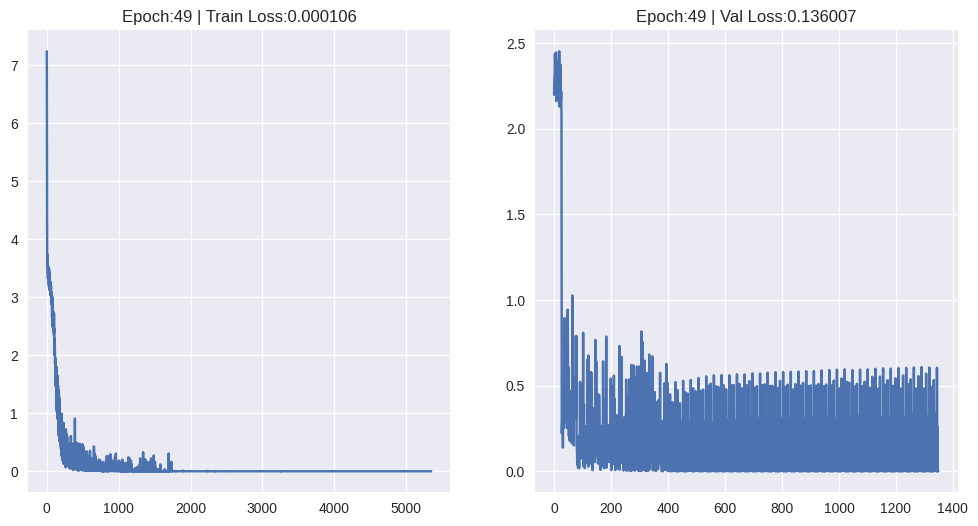

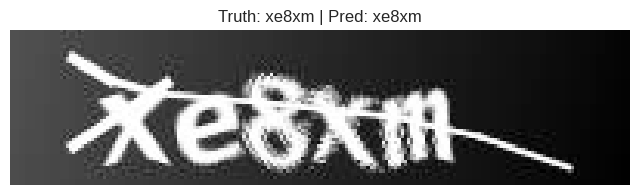

In [32]:
try:
    for epoch in tqdm(range(max_epoch)):
        crnn.train()
        for idx, (batch_imgs, batch_text) in enumerate(train_loader):
            optimizer.zero_grad()
            logits = crnn(batch_imgs.to(device))
            # calculate loss
            train_loss = calculate_loss(logits, batch_text, label_converter)
            if np.isnan(train_loss.detach().cpu().numpy()):
                continue
            train_losses.append(train_loss.item())
            # make backward
            train_loss.backward()

            nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
            optimizer.step()

        val_losses = validation(crnn, val_losses, label_converter)

        scheduler.step(val_losses[-1])

except KeyboardInterrupt:
    pass

# printing progress
plot_loss(epoch, train_losses, val_losses)
print_prediction(crnn, test_dt, device, label_converter)

## Calculating Accuracy and printing prediction

In [33]:
def acc_calc(model, dataset, label_converter) -> float:
    acc = 0
    with torch.no_grad():
        model.eval()
        for idx in range(len(dataset)):
            img, text = dataset[idx]
            logits = model(img.unsqueeze(0).to(device))
            pred_text = decode_prediction(logits.cpu(), label_converter)

            if pred_text == text:
                acc += 1

    return acc / len(dataset)

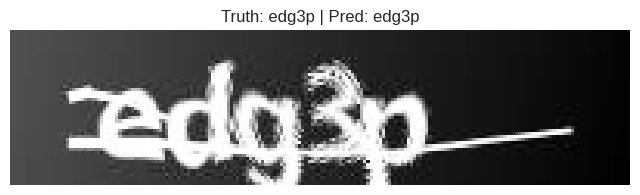

In [34]:
print_prediction(crnn, test_dt, device, label_converter)

In [35]:
val_acc = acc_calc(crnn, test_dt, label_converter)
train_acc = acc_calc(crnn, train_dt, label_converter)
print('Validaton Accuracy: ', val_acc)
print('Training Accuracy: ', train_acc)

Validaton Accuracy:  0.8411214953271028
Training Accuracy:  0.9018691588785047
